# DS 7333 - Quantifying the World
## Case Study #3

Sterling Beason, Sean Kennedy, Emil Ramos

### Introduction

When scrolling through your personal email, it is easy to identify spam mail from a quick glance at the subject line and sender. Although it is not easy to constantly scroll through your email and delete multiple spam mail in a timely manner. So how do we design an automated procedure to classify and eliminate these unwanted messages when scrolling through your inbox?

In order to identify a solution, part of the decision is based on a statistical analysis of the email message that have been hand classified as spam (unwanted mail) or ham (wanted mail). In this case study, we examine the Spam Assassin dataset (http://spamassassin.apache.org) in which we evaluate 9000 emails with spam filters by using a **DecisionTreeClassifier**, a machine learning algorithm which uses recursive partitioning. **SciKit-Learn's** implementation of the algorithm requires the email messages to be transformed into a form conducive to statisitcal analysis. To organize and quantify this information, we can derive variables from characteristics of the messages and use these to classify email. We use a desicion tree that uses derived variables that represent the characteristics of a message, to classify the messages.

### Objective

Using the “emailDFrp” dataset:

1. Build and evaluate a tree-based model for predicting “spam”
2. Plot and analyze the paths through one (or many) of your trees
3. Explain the parameters involved in “tuning” your model
4. Identify which variables were “most” important
5. Explain how to evaluate the “performance” of your model

In [2]:
import pandas as pd
from IPython.display import SVG

# IMPORTANT: install rpy2 v3.3.x
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score
from sklearn.pipeline import Pipeline

# Recommended Installation: 'conda install python-graphviz' (should add 'graphviz' to PATH)
from graphviz import Source
import seaborn as sns

### Import R Data and Convert to Pandas DataFrame

In [3]:
base = importr('base')
base.load("./Data/data.Rda")
rdf_List = base.mget(base.ls())

with localconverter(ro.default_converter + pandas2ri.converter):
    df = ro.conversion.rpy2py(rdf_List[0]) # convert 'emailDFrp' dataset
    
df = df.reset_index()
df = df.drop('index', 1)

df

,isSpam,isRe,underscore,priority,isInReplyTo,sortedRec,subPunc,multipartText,hasImages,isPGPsigned,...,subQuesCt,numAtt,numRec,perCaps,hour,perHTML,subBlanks,forwards,avgWordLen,numDlr
0,F,T,F,F,T,T,F,F,F,F,...,0,0.0,2,4.451039,11.0,0.000000,12.500000,0.000000,4.376623,3
1,F,F,F,F,F,T,F,F,F,F,...,0,0.0,1,7.491289,11.0,0.000000,8.000000,0.000000,4.555556,0
2,F,F,F,F,F,T,F,F,F,F,...,0,0.0,1,7.436096,12.0,0.000000,8.000000,0.000000,4.817164,0
3,F,F,F,F,F,T,F,F,F,F,...,0,0.0,0,5.090909,13.0,0.000000,18.918919,3.125000,4.714286,0
4,F,T,F,F,F,T,F,F,F,F,...,0,0.0,1,6.116643,13.0,0.000000,15.217391,6.451613,4.234940,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9343,T,F,F,F,F,T,F,F,F,F,...,1,0.0,1,8.572552,21.0,79.657111,13.793103,0.000000,4.700555,2
9344,T,F,F,F,F,T,F,T,F,F,...,0,1.0,1,9.436009,23.0,0.000000,10.526316,0.000000,4.904255,4
9345,T,F,F,F,F,F,F,F,F,F,...,0,0.0,1,2.418448,8.0,0.000000,20.000000,0.000000,4.703704,0
9346,T,F,F,F,F,T,F,F,F,F,...,0,0.0,1,7.795400,23.0,0.000000,5.263158,0.000000,5.252690,80


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9348 entries, 0 to 9347
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   isSpam         9348 non-null   category
 1   isRe           9348 non-null   category
 2   underscore     9348 non-null   category
 3   priority       9348 non-null   category
 4   isInReplyTo    9348 non-null   category
 5   sortedRec      9348 non-null   category
 6   subPunc        9348 non-null   category
 7   multipartText  9348 non-null   category
 8   hasImages      9348 non-null   category
 9   isPGPsigned    9348 non-null   category
 10  subSpamWords   9341 non-null   category
 11  noHost         9347 non-null   category
 12  numEnd         9348 non-null   category
 13  isYelling      9341 non-null   category
 14  isOrigMsg      9348 non-null   category
 15  isDear         9348 non-null   category
 16  isWrote        9348 non-null   category
 17  numLines       9348 non-null   in

### Data Dictionary

| Variable | Type | Description |
| - | - | - |
| isRe | logical | TRUE ifRe:appears at the start of the subject. | 
| numLines | integer | Number of lines in the body of the message. | 
| bodyCharCt | integer | Number of characters in the body of the message. | 
| underscore | logical | TRUE if email address in theFromfield of the headercontains an underscore. | 
| subExcCt | integer | Number of exclamation marks in the subject. | 
| subQuesCt | integer | Number of question marks in the subject. | 
| numAtt | integer | Number of attachments in the message. | 
| priority | logical | TRUE if aPrioritykey is present in the header. | 
| numRec | numeric | Number of recipients of the message, including CCs. | 
| perCaps | numeric | Percentage of capitals among all letters in the messagebody, excluding attachments. | 
| isInReplyTo | logical | TRUE if theIn-Reply-Tokey is present in the header. | 
| sortedRec | logical | TRUE if the recipients’ email addresses are sorted. | 
| subPunc | logical | TRUE if words in the subject have punctuation or num-bers embedded in them, e.g.,w!se. | 
| hour | numeric | Hour of the day in theDatefield. | 
| multipartText | logical | TRUE if the MIME type is multipart/text. | 
| hasImages | logical | TRUE if the message contains images. | 
| isPGPsigned | logical | TRUE if the message contains a PGP signature. | 
| perHTML | numeric | Percentage of characters inHTMLtags in the messagebody in comparison to all characters. | 
| subSpamWords | logical | TRUE if the subject contains one of the words in a spamword vector. | 
| subBlanks | numeric | Percentage of blanks in the subject. | 
| noHost | logical | TRUE if there is no hostname in theMessage-Idkey inthe header. | 
| numEnd | logical | TRUE if the email sender’s address (before the @) endsin a number. | 
| isYelling | logical | TRUE if the subject is all capital letters. | 
| forwards | numeric | Number of forward symbols in a line of the body, e.g.,>>> xxxcontains 3 forwards. | 
| isOrigMsg | logical | TRUE if the message body contains the phraseoriginalmessage. | 
| isDear | logical | TRUE if the message body contains the worddear. | 
| isWrote | logical | TRUE if the message contains the phrasewrote:. | 
| avgWordLen | numeric | The average length of the words in a message. | 
| numDlr | numeric | Number of dollar signs in the message body. | 

Converting the **hour** field to categorical since the number of possible values (24) is far less than our number of observations.

In [5]:
df.hour = df.hour.astype('category')

In [6]:
df.columns[df.isna().any() == True]

Index(['subSpamWords', 'noHost', 'isYelling', 'subBlanks'], dtype='object')

###  N/A Impution

There are 4 columns with NAs: 

- subSpamWords (category)

- noHost (category)

- isYelling (category)

- subBlanks (float)

Let's analyze the categorical variables first:

***subSpamWords*** - True if the subject contains one of the words in a spamword vector


In [161]:
df.subSpamWords.unique()

[F, T, NaN]
Categories (2, object): [F, T]

[Text(0, 0, '0'),
 Text(0, 0, '1,000'),
 Text(0, 0, '2,000'),
 Text(0, 0, '3,000'),
 Text(0, 0, '4,000'),
 Text(0, 0, '5,000'),
 Text(0, 0, '6,000'),
 Text(0, 0, '7,000'),
 Text(0, 0, '8,000')]

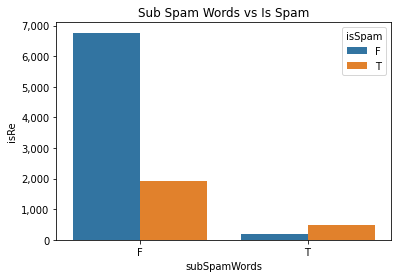

In [162]:
spam_na = df[df.subSpamWords.isna()]
group_by_spam = df.groupby(['subSpamWords', 'isSpam']).count().reset_index()
p1 = sns.barplot(data = group_by_spam, x='subSpamWords', y='isRe', hue='isSpam')
p1.set_title('Sub Spam Words vs Is Spam')
y_ticklabels = [f'{y:,.0f}' for y in p1.get_yticks()]
p1.set_yticklabels(y_ticklabels)

This is just a boolean parameter, let's check the frequency distribution.

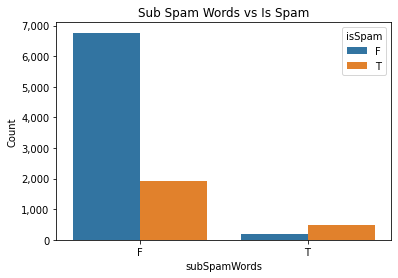

In [7]:
spam_na = df[df.subSpamWords.isna()]
group_by_spam = df.groupby(['subSpamWords', 'isSpam']).count().reset_index().rename(columns={'isRe':'Count'})
p1 = sns.barplot(data = group_by_spam, x='subSpamWords', y='Count', hue='isSpam')
p1.set_title('Sub Spam Words vs Is Spam')
p1.set_yticklabels([f'{y:,.0f}' for y in p1.get_yticks()])
p1

In [8]:
group_by_spam.groupby(['subSpamWords', 'isSpam'])['Count'].sum()

subSpamWords  isSpam
F             F         6768
              T         1929
T             F          176
              T          468
Name: Count, dtype: int64

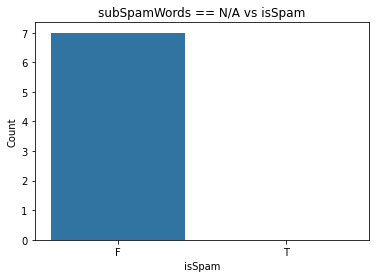

In [9]:
p2 = sns.barplot(data = spam_na.groupby(['isSpam']).count().reset_index().rename(columns={'isRe':'Count'}), x='isSpam', y='Count')
p2.set_title('subSpamWords == N/A vs isSpam')
y_ticklabels = [f'{y:,.0f}' for y in p2.get_yticks()]
p2.set_yticklabels(y_ticklabels)
p2

In [11]:
spam_na.groupby(['isSpam'])['isRe'].count()

isSpam
F    7
T    0
Name: isRe, dtype: int64

From the above, we can see that the ratio of non-spam emails vs. spam emails is higher when **subSpamWords** is False It is the opposite for the case where **subSpamWords** is True. Intuitively, this makes sense, this field indicates the presence of a spam word in the subject line - hence it should be a positive predictor for **isSpam**. Since each of these emails have been classified as not spam, we can safely assume that these are most likely should be imputed to our **False** class for **subSpamWords**. There are 7 observations for this particular field being N/A, so the effect overall of any imputation is likely minimal, at best.

In [14]:
imputed_df = df.copy()
imputed_df.loc[spam_na.index, 'subSpamWords'] = 'F'
assert imputed_df[imputed_df.subSpamWords.isna()].shape[0] == 0

The next field to check N/As for is:

***noHost*** - True if there is no hostname in theMessage-Idkey inthe header.

In [15]:
df.noHost.unique()

[F, T, NaN]
Categories (2, object): [F, T]

Again, this is just a boolean parameter, let's check the frequency distribution.


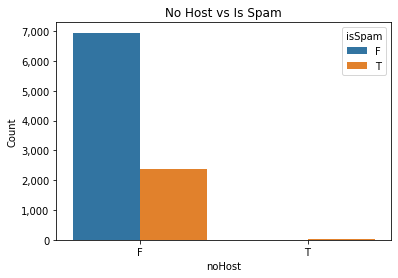

In [17]:
host_na = df[df.noHost.isna()]
group_by_host = df.groupby(['noHost', 'isSpam']).count().reset_index().rename(columns={'isRe':'Count'})
p1 = sns.barplot(data = group_by_host, x='noHost', y='Count', hue='isSpam')
p1.set_title('No Host vs Is Spam')
p1.set_yticklabels([f'{y:,.0f}' for y in p1.get_yticks()])
p1


In [18]:
group_by_host.groupby(['noHost', 'isSpam'])['Count'].sum()

noHost  isSpam
F       F         6951.0
        T         2367.0
T       F            0.0
        T           29.0
Name: Count, dtype: float64

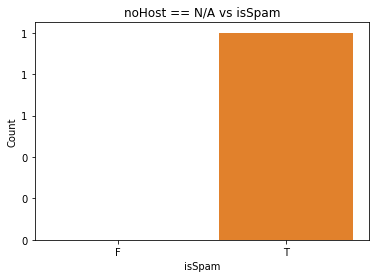

In [19]:
p2 = sns.barplot(data = host_na.groupby(['isSpam']).count().reset_index().rename(columns={'isRe':'Count'}), x='isSpam', y='Count')
p2.set_title('noHost == N/A vs isSpam')
y_ticklabels = [f'{y:,.0f}' for y in p2.get_yticks()]
p2.set_yticklabels(y_ticklabels)
p2

In [20]:
host_na.groupby(['isSpam'])['isRe'].count()

isSpam
F    0
T    1
Name: isRe, dtype: int64

In this case, the **noHost** field only has one N/A, so its impact is negligable - given the observed distribution of this field (strongly tilted towards the **False** class) - it's highly unlikely that this field would e false to begin with, regardless of its classification as spam or not. Hence, we'll impute this value to **False**. 

In [21]:
imputed_df.loc[host_na.index, 'noHost'] = 'F'
assert imputed_df[imputed_df.noHost.isna()].shape[0] == 0

The next field to check N/As for is:

***isYelling*** - True if the subject is all capital letters

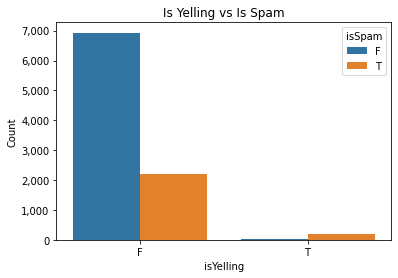

In [22]:
yelling_na = df[df.isYelling.isna()]
group_by_yelling = df.groupby(['isYelling', 'isSpam']).count().reset_index().rename(columns={'isRe':'Count'})
p1 = sns.barplot(data = group_by_yelling, x='isYelling', y='Count', hue='isSpam')
p1.set_title('Is Yelling vs Is Spam')
p1.set_yticklabels([f'{y:,.0f}' for y in p1.get_yticks()])
p1


In [24]:
group_by_yelling.groupby(['isYelling', 'isSpam'])['Count'].sum()

isYelling  isSpam
F          F         6931
           T         2203
T          F           13
           T          194
Name: Count, dtype: int64

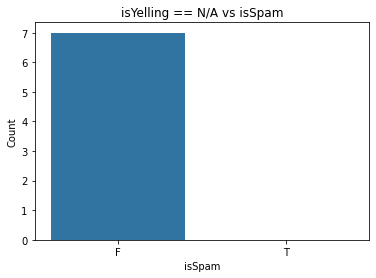

In [25]:
p2 = sns.barplot(data = yelling_na.groupby(['isSpam']).count().reset_index().rename(columns={'isRe':'Count'}), x='isSpam', y='Count')
p2.set_title('isYelling == N/A vs isSpam')
y_ticklabels = [f'{y:,.0f}' for y in p2.get_yticks()]
p2.set_yticklabels(y_ticklabels)
p2

In [26]:
yelling_na.groupby(['isSpam'])['isRe'].count()

isSpam
F    7
T    0
Name: isRe, dtype: int64

From the above, we can see that the ratio of non-spam emails vs. spam emails is higher when **isYelling** is False. It is the opposite for the case where **isYelling** is True, nearly all of those observations were spam emails (194/207). Since each of these emails have been classified as not spam, we can safely assume that these should be imputed to our **False** class for **isYelling**. There are 7 observations for this particular field being N/A, so the effect overall of any imputation is likely minimal, at best.


In [27]:
imputed_df.loc[yelling_na.index, 'isYelling'] = 'F'
assert imputed_df[imputed_df.isYelling.isna()].shape[0] == 0

The next field to check N/As for is:

***subBlanks*** - Percentage of blanks in the subject.

We'll handle this slightly differently than other fields since it's a float, not a categorical.

In [28]:
df[df.subBlanks.isna()].groupby(['isSpam'])[['isRe']].count().rename(columns={'isRe':'Count'})

,Count
isSpam,
F,7
T,13


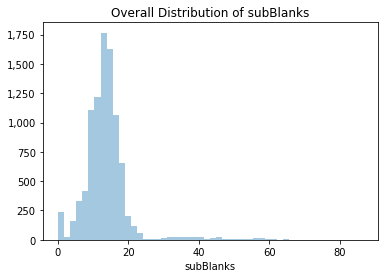

In [38]:
not_na = df[~df.subBlanks.isna()]['subBlanks']
p = sns.distplot(not_na, kde=False)
p.set_title('Overall Distribution of subBlanks')
y_ticklabels = [f'{y:,.0f}' for y in p.get_yticks()]
p.set_yticklabels(y_ticklabels)
p

In [40]:
print(not_na.describe())
print(f'Median = {round(not_na.median(), 4)}')

count    9328.000000
mean       13.866939
std         7.431938
min         0.000000
25%        10.526316
50%        13.253012
75%        15.686275
max        86.419753
Name: subBlanks, dtype: float64
Median = 13.253


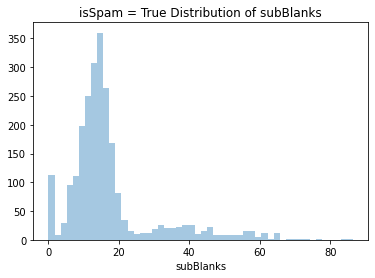

In [43]:
true_na = df[(~df.subBlanks.isna())
& (df.isSpam == 'T')
]['subBlanks']

p = sns.distplot(true_na, kde=False)
p.set_title('isSpam = True Distribution of subBlanks')
y_ticklabels = [f'{y:,.0f}' for y in p.get_yticks()]
p.set_yticklabels(y_ticklabels)
p

In [51]:
print(true_na.describe())
print(round(true_na.median(),4))

count    2384.000000
mean       17.078511
std        12.584919
min         0.000000
25%        10.526316
50%        14.285714
75%        17.777778
max        86.419753
Name: subBlanks, dtype: float64
14.2857


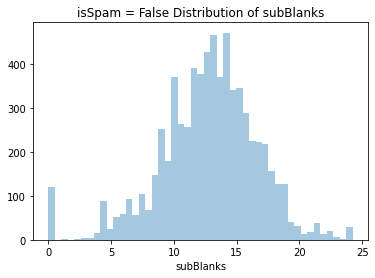

In [44]:
false_na = df[(~df.subBlanks.isna())
& (df.isSpam == 'F')
]['subBlanks']

p = sns.distplot(false_na, kde=False)
p.set_title('isSpam = False Distribution of subBlanks')
y_ticklabels = [f'{y:,.0f}' for y in p.get_yticks()]
p.set_yticklabels(y_ticklabels)
p

In [49]:
print(false_na.describe())
print(round(false_na.median(), 4))

count    6944.000000
mean       12.764349
std         3.883546
min         0.000000
25%        10.416667
50%        13.043478
75%        15.384615
max        24.242424
Name: subBlanks, dtype: float64
13.0435


In this case we see an interesting situation, **subBlanks** for the True/False class (**isSpam**) appear to have very different distributions - skewed highly towards higher numbers for our True class, far more normal for our False class. 

For our N/A data, **65%** (13/20) of our observations **are spam** - assigning them values from the overall distribution (whether using the mean or median) could be problematic. We'll opt for an imputation scheme where we impute our True labeled N/As to the **mean** of observations that have been observed as spam and observations where our label is False to the **mean** of observations that are not spam.

In the wild, we will not have the option of knowing beforehand whether or not a message is spam, so we will opt to impute N/As for this field to the **mean** of our training set (after applying the impution scheme described above).

### Data Partioning

We will use an 80/20 train test split for our data (80% train/test - 20% validation)

For our **GridSearchCV**, we will perform a 5 fold **StratifiedShuffleSplit** for model tuning/selection.

In [163]:
#df = df.dropna() # TODO: Impute NAs, don't drop them

features = df[df.columns.difference(['isSpam'])]


X = pd.get_dummies(features, drop_first=True)
y = df['isSpam'].astype('object').apply(lambda x: 1 if x == 'T' else 0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7333)

### Modeling - Decision Tree

In [164]:
clf = DecisionTreeClassifier(random_state=7333)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

# Accuracy
precision_score(y_test, pred)

0.9386892177589852

In [165]:
clf.__dict__

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'random_state': 7333,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'class_weight': None,
 'presort': 'deprecated',
 'ccp_alpha': 0.0,
 'n_features_': 51,
 'n_outputs_': 1,
 'classes_': array([0, 1]),
 'n_classes_': 2,
 'max_features_': 51,
 'tree_': <sklearn.tree._tree.Tree at 0x7fda656ab3d8>}

### Cross Validation

5-fold 80/20 stratified shuffle split

In [166]:
n_splits = 5
cv = StratifiedShuffleSplit(n_splits,test_size=.2, train_size=.8, random_state=7333)

### Tuneable Parameters

We selected precision as our scoring metric to evaluate the performance of our model because it highlights how precise/accurate our model by adding both the true positive and false positive to get a total predicted positive score. It is also a good measure to determine when the costs of false positive is high. In our case study, a false positive means that an email that is ham (actual negative) has been identified as spam (predicted spam). The precision score for our spam detection model must be high to prevent the loss of important emails. Our goal is to minimize the amount of false positives, and false negatives within the resulting confusion matrix's.

- SK to add color for each

In [230]:
criteria = ['gini', 'entropy'] # define possible splitting criteria
splitters = ['best', 'random'] 
max_depth = list(range(20, 50, 5))
min_samples_split = list(range(3, 5, 1))
min_samples_leaf = list(range(2, 5, 1))
max_features = ['auto', 'sqrt', 'log2']
random_state = 7333
max_leaf_nodes = list(range(5, 20, 3))
scoring = {
           # 'Accuracy':'accuracy'
           # , 'F-1 Score':'f1'
           # , 'AUC':'roc_auc'
             'Precision':'precision'
}

### Model Tuning

General grid search:

In [231]:
pipe = Pipeline(steps=[('decision_tree', clf)])
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 #'decision_tree__criterion':criteria,
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.1s


Precision score of best estimator: 0.9122448979591836


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [232]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='best'))],
         verbose=False)

In [233]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).T
print(sorted_results[1].params)
sorted_results

{'decision_tree__criterion': 'entropy'}


,1,0
split0_test_Precision,0.916883,0.921409
split1_test_Precision,0.904762,0.907162
split2_test_Precision,0.951351,0.942779
split3_test_Precision,0.935135,0.912234
split4_test_Precision,0.933333,0.905852
mean_test_Precision,0.928293,0.917887
std_test_Precision,0.0160487,0.013593
rank_test_Precision,1,2
params,{'decision_tree__criterion': 'entropy'},{'decision_tree__criterion': 'gini'}


**Entropy** appears slightly better with a mean precision score at 0.92 given that this precision is worse than baseline. We should continue our search and consider opting for **gini** if further tuning prefers it, since entropy might be a slightly slower to compute.

In [234]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Precision score of best estimator: 0.9122448979591836


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.3s finished


In [235]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='best'))],
         verbose=False)

In [236]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).T
print(sorted_results[1].params)
sorted_results

{'decision_tree__criterion': 'gini', 'decision_tree__splitter': 'random'}


,2,1,3,0
split0_test_Precision,0.916883,0.915789,0.905263,0.921409
split1_test_Precision,0.904762,0.893229,0.92328,0.907162
split2_test_Precision,0.951351,0.941341,0.921196,0.942779
split3_test_Precision,0.935135,0.941176,0.936111,0.912234
split4_test_Precision,0.933333,0.909561,0.909326,0.905852
mean_test_Precision,0.928293,0.920219,0.919035,0.917887
std_test_Precision,0.0160487,0.0186923,0.0109381,0.013593
rank_test_Precision,1,2,3,4
params,"{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision..."


Although **entropy** scored slightly better with a mean precison score of 0.928 vs **gini** mean precision score at 0.920, we felt that **gini** is preferred when split is **random** because **gini** measurement is the probability of a random sample being classified incorrectly if we randomly pick a label according to the distribution in a branch.

In [237]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 'decision_tree__max_depth':max_depth,
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s


Precision score of best estimator: 0.9540481400437637


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.1s finished


In [238]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=20,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='best'))],
         verbose=False)

In [239]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).T
print(sorted_results[1].params)
sorted_results

{'decision_tree__criterion': 'gini', 'decision_tree__max_depth': 20, 'decision_tree__splitter': 'random'}


,0,1,12,2,14,5,20,22,18,16,...,19,17,4,11,21,10,8,6,13,23
split0_test_Precision,0.938028,0.934473,0.919355,0.923288,0.923077,0.930108,0.916883,0.916883,0.916883,0.915567,...,0.917772,0.902703,0.921409,0.915789,0.917808,0.921409,0.921409,0.921409,0.920765,0.905263
split1_test_Precision,0.930556,0.930168,0.904639,0.920981,0.895141,0.92328,0.904762,0.904762,0.904762,0.904762,...,0.908854,0.918635,0.916442,0.893229,0.905263,0.907162,0.907162,0.907162,0.896373,0.885204
split2_test_Precision,0.956647,0.951009,0.945055,0.955182,0.945946,0.94302,0.951351,0.951351,0.951351,0.950954,...,0.924324,0.933884,0.942623,0.941341,0.921196,0.942779,0.942779,0.942779,0.931624,0.921196
split3_test_Precision,0.945087,0.952522,0.952646,0.936111,0.950139,0.935754,0.935135,0.935135,0.935135,0.935135,...,0.936111,0.932961,0.922865,0.941176,0.936111,0.912234,0.912234,0.912234,0.934911,0.936111
split4_test_Precision,0.927614,0.926966,0.939726,0.920844,0.932796,0.913613,0.933333,0.933333,0.933333,0.930108,...,0.927224,0.925729,0.906494,0.909561,0.909326,0.905852,0.905852,0.905852,0.894872,0.909326
mean_test_Precision,0.939586,0.939028,0.932284,0.931281,0.92942,0.929155,0.928293,0.928293,0.928293,0.927305,...,0.922857,0.922783,0.921967,0.920219,0.917941,0.917887,0.917887,0.917887,0.915709,0.91142
std_test_Precision,0.0104753,0.0106806,0.017689,0.0132174,0.0196421,0.0101269,0.0160487,0.0160487,0.0160487,0.0159649,...,0.00915238,0.0114537,0.011813,0.0186923,0.0107303,0.013593,0.013593,0.013593,0.0170625,0.0169398
rank_test_Precision,1,2,3,4,5,6,7,7,7,10,...,15,16,17,18,19,20,20,20,23,24
params,"{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...",...,"{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis..."


After setting the max_depth = 20, the precision score seems to have a sizeable improvement at 0.93, let's keep that in mind.

In [240]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 'decision_tree__max_depth':max_depth,
                                 'decision_tree__min_samples_split': min_samples_split
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s


Precision score of best estimator: 0.9518599562363238


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.0s finished


In [241]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=20,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='best'))],
         verbose=False)

In [242]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).T
print(sorted_results[1].params)
sorted_results

{'decision_tree__criterion': 'gini', 'decision_tree__max_depth': 20, 'decision_tree__min_samples_split': 3, 'decision_tree__splitter': 'random'}


,0,9,1,21,29,2,17,13,3,26,...,22,18,14,41,47,39,43,45,37,27
split0_test_Precision,0.937677,0.951289,0.940678,0.941989,0.921127,0.935028,0.929919,0.937669,0.926136,0.921833,...,0.915761,0.915761,0.915761,0.916216,0.918033,0.914601,0.910326,0.914209,0.903485,0.909605
split1_test_Precision,0.938028,0.907162,0.92011,0.921196,0.936986,0.925414,0.918206,0.917772,0.921348,0.903394,...,0.909333,0.909333,0.909333,0.923706,0.916667,0.915567,0.918919,0.917989,0.904762,0.887399
split2_test_Precision,0.962428,0.946479,0.948424,0.930481,0.940845,0.956772,0.929972,0.954802,0.941349,0.944134,...,0.934247,0.934247,0.934247,0.927614,0.914667,0.93733,0.916667,0.927614,0.938172,0.919771
split3_test_Precision,0.942197,0.958333,0.947977,0.94382,0.933884,0.944444,0.94382,0.924791,0.951807,0.94958,...,0.922865,0.922865,0.922865,0.90566,0.917808,0.922865,0.917808,0.90566,0.90566,0.90411
split4_test_Precision,0.931694,0.937158,0.94302,0.95082,0.954416,0.916442,0.95082,0.93531,0.927978,0.93733,...,0.913158,0.913158,0.913158,0.915789,0.917553,0.893229,0.917553,0.915789,0.92126,0.930168
mean_test_Precision,0.942405,0.940084,0.940042,0.937661,0.937452,0.93562,0.934547,0.934069,0.933724,0.931254,...,0.919073,0.919073,0.919073,0.917797,0.916946,0.916718,0.916255,0.916252,0.914668,0.91021
std_test_Precision,0.0105564,0.0178433,0.0103901,0.0105116,0.0107587,0.0141251,0.0114906,0.0126178,0.0112151,0.0167545,...,0.00877994,0.00877994,0.00877994,0.00755132,0.00123017,0.014284,0.00305011,0.00705241,0.013418,0.0144749
rank_test_Precision,1,2,3,4,5,6,7,8,9,10,...,39,39,39,42,43,44,45,46,47,48
params,"{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...",...,"{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis..."


After tuning the **min_samples_split** to 3, the results seem to best at the lowest possible value: explanation?

In [243]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 'decision_tree__max_depth':max_depth,
                                 'decision_tree__min_samples_split': min_samples_split,
                                 'decision_tree__min_samples_leaf': min_samples_leaf,
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.7s


Precision score of best estimator: 0.9309576837416481


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    6.5s finished


In [244]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=20,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='random'))],
         verbose=False)

In [245]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).T
print(sorted_results[1].params)
sorted_results

{'decision_tree__criterion': 'gini', 'decision_tree__max_depth': 20, 'decision_tree__min_samples_leaf': 2, 'decision_tree__min_samples_split': 3, 'decision_tree__splitter': 'random'}


,1,3,0,2,15,13,74,72,51,49,...,125,127,139,137,119,117,141,129,131,143
split0_test_Precision,0.937143,0.937143,0.936599,0.936599,0.929972,0.929972,0.918033,0.918033,0.928177,0.928177,...,0.904632,0.904632,0.904632,0.904632,0.889503,0.889503,0.870712,0.870712,0.870712,0.870712
split1_test_Precision,0.945402,0.945402,0.94051,0.94051,0.922636,0.922636,0.915567,0.915567,0.928775,0.928775,...,0.875325,0.875325,0.870647,0.870647,0.893506,0.893506,0.893506,0.893506,0.893506,0.893506
split2_test_Precision,0.942363,0.942363,0.95858,0.95858,0.949102,0.949102,0.946176,0.946176,0.948171,0.948171,...,0.888,0.888,0.888,0.888,0.875,0.875,0.875,0.875,0.875,0.875
split3_test_Precision,0.96,0.96,0.944606,0.944606,0.957447,0.957447,0.943662,0.943662,0.926136,0.926136,...,0.888889,0.888889,0.888889,0.888889,0.880223,0.880223,0.880223,0.880223,0.880223,0.880223
split4_test_Precision,0.931818,0.931818,0.918033,0.918033,0.919668,0.919668,0.943662,0.943662,0.928571,0.928571,...,0.884021,0.884021,0.877238,0.877238,0.887363,0.887363,0.887363,0.887363,0.887363,0.887363
mean_test_Precision,0.943345,0.943345,0.939666,0.939666,0.935765,0.935765,0.93342,0.93342,0.931966,0.931966,...,0.888173,0.888173,0.885881,0.885881,0.885119,0.885119,0.881361,0.881361,0.881361,0.881361
std_test_Precision,0.00952806,0.00952806,0.0131168,0.0131168,0.0149199,0.0149199,0.0136234,0.0136234,0.0081565,0.0081565,...,0.00952647,0.00952647,0.0115925,0.0115925,0.00664782,0.00664782,0.00823023,0.00823023,0.00823023,0.00823023
rank_test_Precision,1,1,3,3,5,5,7,7,9,9,...,135,135,137,137,139,139,141,141,141,141
params,"{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...",...,"{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis..."


Tuning min_samples leaf from 1 to 2, made things worse....

In [246]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 'decision_tree__max_depth':max_depth,
                                 'decision_tree__min_samples_split': min_samples_split,
                                 'decision_tree__min_samples_leaf': min_samples_leaf,
                                 'decision_tree__max_features': max_features
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    4.7s


Precision score of best estimator: 0.9151376146788991


[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:    7.7s finished


In [247]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=20,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='best'))],
         verbose=False)

In [249]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).T
print(sorted_results[1].params)
sorted_results

{'decision_tree__criterion': 'gini', 'decision_tree__max_depth': 20, 'decision_tree__max_features': 'auto', 'decision_tree__min_samples_leaf': 2, 'decision_tree__min_samples_split': 3, 'decision_tree__splitter': 'random'}


,0,2,14,12,266,264,254,252,278,276,...,117,119,129,131,35,33,273,263,261,275
split0_test_Precision,0.92515,0.92515,0.92515,0.92515,0.908333,0.908333,0.908333,0.908333,0.90678,0.90678,...,0.812332,0.812332,0.812332,0.812332,0.755611,0.755611,0.84438,0.84438,0.84438,0.84438
split1_test_Precision,0.927978,0.927978,0.927978,0.927978,0.919137,0.919137,0.919137,0.919137,0.916667,0.916667,...,0.88724,0.88724,0.88724,0.88724,0.871429,0.871429,0.867403,0.867403,0.867403,0.867403
split2_test_Precision,0.932153,0.932153,0.932153,0.932153,0.93787,0.93787,0.93787,0.93787,0.925501,0.925501,...,0.822674,0.822674,0.822674,0.822674,0.894389,0.894389,0.814917,0.814917,0.814917,0.814917
split3_test_Precision,0.915205,0.915205,0.915205,0.915205,0.919308,0.919308,0.919308,0.919308,0.915916,0.915916,...,0.869301,0.869301,0.869301,0.869301,0.918149,0.918149,0.835509,0.835509,0.835509,0.835509
split4_test_Precision,0.894737,0.894737,0.894737,0.894737,0.895317,0.895317,0.895317,0.895317,0.9,0.9,...,0.84359,0.84359,0.84359,0.84359,0.789598,0.789598,0.85989,0.85989,0.85989,0.85989
mean_test_Precision,0.919044,0.919044,0.919044,0.919044,0.915993,0.915993,0.915993,0.915993,0.912973,0.912973,...,0.847028,0.847028,0.847028,0.847028,0.845835,0.845835,0.84442,0.84442,0.84442,0.84442
std_test_Precision,0.0133756,0.0133756,0.0133756,0.0133756,0.0140403,0.0140403,0.0140403,0.0140403,0.00878546,0.00878546,...,0.0280065,0.0280065,0.0280065,0.0280065,0.0625219,0.0625219,0.0185331,0.0185331,0.0185331,0.0185331
rank_test_Precision,1,1,1,1,5,5,5,5,9,9,...,423,423,423,423,427,427,429,429,429,429
params,"{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...",...,"{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis..."


### Conclusion

Tuning **max_features** gave best outcome so far.

In [250]:
clf_pipe = GridSearchCV(pipe
                   , cv=cv
                   ,param_grid = {
                                 'decision_tree__criterion':criteria,
                                 'decision_tree__splitter':splitters,
                                 'decision_tree__max_depth':max_depth,
                                 'decision_tree__min_samples_split': min_samples_split,
                                 'decision_tree__min_samples_leaf': min_samples_leaf,
                                 'decision_tree__max_features': max_features,
                                 'decision_tree__max_leaf_nodes': max_leaf_nodes,
                                 }
                   , verbose=True
                   , n_jobs=-1
                   , scoring=scoring
                   , refit='Precision'
                   , error_score=0.0)
clf_fit = clf_pipe.fit(X_train, y_train.values.ravel())
clf_predict = clf_fit.best_estimator_.predict(X_test)
print(f'Precision score of best estimator: {precision_score(y_test, clf_predict)}')

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   16.2s


Precision score of best estimator: 0.985


[Parallel(n_jobs=-1)]: Done 10800 out of 10800 | elapsed:   29.4s finished


In [251]:
clf_fit.best_estimator_

Pipeline(memory=None,
         steps=[('decision_tree',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=20,
                                        max_features='log2', max_leaf_nodes=8,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=3, min_samples_split=3,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=7333,
                                        splitter='random'))],
         verbose=False)

In [252]:
results = pd.DataFrame(clf_fit.cv_results_)
scores = [col for col in results.columns if 'test_Precision' in col]
scores.append('params')
sorted_results = results[scores].sort_values(['rank_test_Precision']).T
print(sorted_results[1].params)
sorted_results

{'decision_tree__criterion': 'gini', 'decision_tree__max_depth': 20, 'decision_tree__max_features': 'auto', 'decision_tree__max_leaf_nodes': 5, 'decision_tree__min_samples_leaf': 2, 'decision_tree__min_samples_split': 3, 'decision_tree__splitter': 'random'}


,2123,1763,1757,1397,1399,1943,1941,1939,1223,2117,...,749,29,751,815,27,753,453,985,989,987
split0_test_Precision,0.987097,0.987097,0.987097,0.987097,0.987097,0.987097,0.987097,0.987097,0.987097,0.987097,...,0.728125,0.728125,0.728125,0.728125,0.728125,0.728125,0.728125,0.728125,0.728125,0.728125
split1_test_Precision,1,1,1,1,1,1,1,1,1,1,...,0.634694,0.634694,0.634694,0.634694,0.634694,0.634694,0.634694,0.634694,0.634694,0.634694
split2_test_Precision,0.992908,0.992908,0.992908,0.992908,0.992908,0.992908,0.992908,0.992908,0.992908,0.992908,...,0.62963,0.62963,0.62963,0.62963,0.62963,0.62963,0.62963,0.62963,0.62963,0.62963
split3_test_Precision,0.980132,0.980132,0.980132,0.980132,0.980132,0.980132,0.980132,0.980132,0.980132,0.980132,...,0.621032,0.621032,0.621032,0.621032,0.621032,0.621032,0.621032,0.621032,0.621032,0.621032
split4_test_Precision,0.993197,0.993197,0.993197,0.993197,0.993197,0.993197,0.993197,0.993197,0.993197,0.993197,...,0.724919,0.724919,0.724919,0.724919,0.724919,0.724919,0.724919,0.724919,0.724919,0.724919
mean_test_Precision,0.990667,0.990667,0.990667,0.990667,0.990667,0.990667,0.990667,0.990667,0.990667,0.990667,...,0.66768,0.66768,0.66768,0.66768,0.66768,0.66768,0.66768,0.66768,0.66768,0.66768
std_test_Precision,0.00666711,0.00666711,0.00666711,0.00666711,0.00666711,0.00666711,0.00666711,0.00666711,0.00666711,0.00666711,...,0.0482533,0.0482533,0.0482533,0.0482533,0.0482533,0.0482533,0.0482533,0.0482533,0.0482533,0.0482533
rank_test_Precision,1,1,1,1,1,1,1,1,1,1,...,2089,2089,2089,2089,2089,2089,2089,2089,2089,2089
params,"{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...","{'decision_tree__criterion': 'entropy', 'decis...",...,"{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision...","{'decision_tree__criterion': 'gini', 'decision..."


### Display Decision Tree

**Note:** You may have to scroll to view

In [208]:
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=X.columns, class_names=['spam', 'ham'], filled = True))

display(SVG(graph.pipe(format='svg')))

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH